<center>

## Машинное обучение

</center>

В нашей работе мы хотели бы предсказывать такую перемнную, как рейтинг, поскольку возможность предугадывать данный показатель поможет как создателям (анализировать предпочтения зрителей и заранее определить успех проекта), так и зрителям (стоит ли идти на премьеру того или иного фильма).
В связи с тем, что таргетная перемнная принадлежит к классу числовых величин, мы будем обучать Линейную регрессию и её разновидности. Оценивать результаты предсказаний моделей мы будем, опираясь на метрики MSE и MAE. Наш выбор связан с тем, что MSE придаёт большую значимость грубым ошибкам, то есть минимизируя её, мы можем добиться результата, когда модель предсказывает не совсем отличные от истины значения, но она чувствительна к выбросам, что в дальнейшем нам объяснит причину достижения не совсем маленького значения при многократной оптимизации моделей. С противоположной стороны MAE, наоборот, не придаёт большого значения предсказаниям, далеко расположенным от изначальных, то есть она меньше подтвержена выбросам, которые присутствуют в нашем датафрейме.

__Импортируем необходимые библиотеки__

In [57]:
from collections import defaultdict as dd
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna

Загружаем наш исходный файл уже с преобразованием EDA и с новыми двумя признаками

In [2]:
df=pd.read_csv('project_new_feature_year_class.csv')
df

,Название,Страна,Жанр,Год выпуска,Давность,Возрастное ограничение,Категория,Продолжительность,Рейтинг
0,"На солнце, вдоль рядов кукурузы",Россия,Драмы,2023,0,6,Детское,89,8.4
1,Беспринципные в деревне,Россия,Комедии,2023,0,18,Взрослое,86,7.2
2,Нюрнберг,Россия,Драмы,2023,0,12,Подростковое,124,8.1
3,Моё прекрасное несчастье,США,Комедии,2023,0,18,Взрослое,91,7.7
4,Взломщик,США,Криминал,2023,0,18,Взрослое,91,6.5
...,...,...,...,...,...,...,...,...,...
2056,Марионетка,Нидерланды,Триллеры,2020,3,18,Взрослое,107,6.5
2057,Русалка. Озеро мертвых,Россия,Ужасы,2018,5,16,Подростковое,83,5.5
2058,Форсаж 4,США,Криминал,2009,14,16,Подростковое,106,8.8
2059,Полночь на злаковом поле,США,Триллеры,2021,2,16,Подростковое,98,6.7


## Применение простейших моделей 

__Деление выборки на обучающую и тестовую__

In [3]:
df_train, df_test = train_test_split(df, test_size=0.2,random_state=45) #решили как обычно поделить на 80/20% для упрощения ))
y_train = df_train['Рейтинг'] #это наша таргетная переменная 
y_test = df_test['Рейтинг'] 
X_train = df_train.drop(['Рейтинг','Название'], axis=1) #удаляем столбцы, которые не будут использоваться в качестве объясняющих признаков
X_test = df_test.drop(['Рейтинг','Название'], axis=1)

In [4]:
numeric_features= X_train.select_dtypes([np.number]).columns #сохраняем названия колонок с категориальными и числовыми данными
categorical_features= X_train.dtypes[X_train.dtypes == "object"].index
print(numeric_features)
print(categorical_features)

Index(['Год выпуска', 'Давность', 'Возрастное ограничение',
       'Продолжительность'],
      dtype='object')
Index(['Страна', 'Жанр', 'Категория'], dtype='object')


In [5]:
model=LinearRegression() #обучаем простейшую линейную регрессию без параметров 
model.fit(X_train[numeric_features], y_train)
y_pred=model.predict(X_test[numeric_features])

In [8]:
print("MSE = %.4f" % metrics.mean_squared_error(y_test, y_pred))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test, y_pred))

MSE = 0.8703
MAE = 0.7034


__Промежуточный вывод:__

Из результатов модели мы наблюдаем высокие значения ошибки MAE и MSE, что говорит о высоких расхождениях между предсказанными и настоящими величинами. Поэтому,возможно, необходимо преобразовать категориальные переменные.
Чтобы наша модель получала больше признаков на вход, следует применить OneHotEncoding к переменным object. Таким образом, в нашем датафрейме увеличится число фичей, которые могут поспособствовать улучшению обучения модели.

## Преобразование значений в датафрейме

In [9]:
df_ohe=df.drop(['Название'],axis=1).copy() #сохраняем таблицу без Названий фильмов, что не применить к ним случайно OHE

In [30]:
df_ohe=pd.get_dummies(df_ohe) #применяем OHE и увеличиваем число признаков с 7 до 54 (не считая таргетную перемнную)
df_ohe.head()

,Год выпуска,Давность,Возрастное ограничение,Продолжительность,Рейтинг,Страна_Австралия,Страна_Великобритания,Страна_Германия,Страна_Дания,Страна_Ирландия,...,Жанр_Триллеры,Жанр_Ужасы,Жанр_Фантастика,Жанр_Футбол,Жанр_Фэнтези,Жанр_Экранизации,Жанр_спектакли,Категория_Взрослое,Категория_Детское,Категория_Подростковое
0,2023,0,6,89,8.4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2023,0,18,86,7.2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2023,0,12,124,8.1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2023,0,18,91,7.7,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2023,0,18,91,6.5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
df_train_ohe, df_test_ohe = train_test_split(df_ohe, test_size=0.2,random_state=45)
y_train_ohe = df_train_ohe['Рейтинг'] #всё также по-прежнему делим датафрейм на обучающую и тестовую выборки 
y_test_ohe = df_test_ohe['Рейтинг'] 
X_train_ohe = df_train_ohe.drop(['Рейтинг'], axis=1)
X_test_ohe = df_test_ohe.drop(['Рейтинг'], axis=1)

In [12]:
model_ohe=LinearRegression() #обучаем простейшую Линейную регрессию на новом датафрейме
model_ohe.fit(X_train_ohe, y_train_ohe)
y_pred_ohe=model_ohe.predict(X_test_ohe)

In [13]:
print("MSE = %.4f" % metrics.mean_squared_error(y_test_ohe, y_pred_ohe))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_ohe,y_pred_ohe))

MSE = 0.7456
MAE = 0.6533


__Промежуточный вывод:__

Заметим, что, применяя _one_hot_encoding_, абсолютно все метрики улучшились, давая меньшую ошибку. Поэтому работаем дальше с этими данными, применяя к ним иные способы трансформации значений объясняющих переменных. Например, попробуем стандартизировать наши числовые значения.

In [17]:
scaler=StandardScaler() #определяем функцию стандартизации и применяем её к тестовой и обучающей выборкам
X_train_ohe_scaled= scaler.fit_transform(X_train_ohe[['Год выпуска','Продолжительность','Давность','Возрастное ограничение']])
X_test_ohe_scaled= scaler.transform(X_test_ohe[['Год выпуска','Продолжительность','Давность','Возрастное ограничение']])

In [18]:
model_ohe_scaler=LinearRegression() #обучаем модель с учетом стандартизации и OHE
model_ohe_scaler.fit(X_train_ohe_scaled, y_train_ohe)
y_pred_ohe_scaler=model_ohe_scaler.predict(X_test_ohe_scaled)

In [20]:
print("MSE = %.4f" % metrics.mean_squared_error(y_test_ohe, y_pred_ohe_scaler))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_ohe,y_pred_ohe_scaler))

MSE = 0.8702
MAE = 0.7033


__Промежуточный вывод:__

Скалирование значений преобразованного датасета не даёт нам улучшения метрик, потому что они принимают значения, которые эквивалентны результатам обучения простейшей модели Линейной регрессии без параметров ((
Тем не менее, этот результат ожидаем, поскольку моделе, скорее всего, сложно обучиться и понять закономерности входных параметров, когда в датафрейме присутствуют не только числовые показатели нормального распределения, но и категориальные величины, принимающие значения 1 и 0.
Несмотря на это, попробуем одновременно применить к изначальному датафрейму стандартизацию и OHE с помощью функции ColumnTransformer, может станет лучше )) 

In [21]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),    
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)])

In [22]:
model_lr = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegression(n_jobs=-1))])
model_pipe =model_lr.fit(X_train, y_train)
y_pred_pipe = model_pipe.predict(X_test)

In [24]:
print("MSE = %.4f" % metrics.mean_squared_error(y_test, y_pred_pipe))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test, y_pred_pipe))

MSE = 0.7454
MAE = 0.6535


__Промежуточный вывод:__

Используя column_transformer вместе с Pipeline, мы, однако, получаем метрики лучше, чем при последовательном преобразовании  категориальных переменных через one_hot_encoding и стандартизации чисел. Но всё же наши метрики велики, поскольку при изолированном применении лишь OHE мы достигали идентичного результата (((

## Боремся с возможным переобучением модели через Ridge и Lasso регрессии

__Начнём с Ridge регрессии__

In [25]:
# обучаем модель на данных с преобразованными категориальными перменными (т.к. до этого эта трансформация давала лучшие метрики)
model_r = Ridge(alpha=20) # альфа параметр данной модели, предположим он будет равен 20 

model_r.fit(X_train_ohe, y_train_ohe)
y_pred_r = model_r.predict(X_test_ohe)

In [27]:
print("MSE = %.4f" % metrics.mean_squared_error(y_test_ohe, y_pred_r))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_ohe, y_pred_r))

MSE = 0.7553
MAE = 0.6514


Пока метрики не поменялись (после обучения Ridge регрессии), поэтому попробуем подобрать параметры для этой модели с помощью перебора по сетке. Может, подобранные оптимальные значения параметров модели дадут лучший результат. 

In [28]:
alpha = np.logspace(-10, 100,1000) # взяли широкий интервал значений для возможности выбора наиболее подходящего
parametr={'alpha':alpha} #решили подбирать наиболее значимый параметр, коэффициент регуляризации, отвечающий за переобучение 
#модели и за веса признаков в ней

ridge=Ridge(random_state=45)
searcher = GridSearchCV(
    ridge, parametr, 
    scoring="neg_root_mean_squared_error", cv=10,n_jobs=-1) #решили сделать кросс-валидацию на 10 фолдах, потому что таким образом
#в одном фолде получается около 200 наблюдений

searcher.fit(X_train_ohe, y_train_ohe) #по-прежнему обучаемся на данных уже с OHE
print(searcher.best_params_["alpha"])
print(searcher.best_score_)

3.720236681413066
-0.8728844494010802


In [31]:
y_pred_r_search = searcher.predict(X_test_ohe)
print("MSE = %.4f" % metrics.mean_squared_error(y_test_ohe, y_pred_r_search))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_ohe, y_pred_r_search))

MSE = 0.7474
MAE = 0.6515


После попытки подобрать оптимальные параметры для Ridge регрессии значения наших метрик изменились только в тысячных, что не говорит о хорошем обучении модели. Теперь снова воспользуемся Pipeline и последовательном Column_transformer и подберем, и обучим нашу модель на исходных данных.

In [32]:
alpha = np.logspace(-10, 100, 55) #решили пропробовать рассмотреть меньшее кол-во значений для параметра alpha, чтобы код грузился быстрее
param_grid = {'regression__alpha': alpha}  # всё также указываем параметр alpha для модели Ridge 

model_ridge = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(random_state=45)) #применяем функцию Column_transformer и объявляем моель
])
searcher2 = GridSearchCV(
    model_ridge, param_grid,
    scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1 # решили оптимизироваться на минимизации ошибки MSE, поскольку оно 
)                                                   # в себе содержит квадрат отклонений, поэтому, скорее всего, MAE в таком случае тоже улучшится
searcher2.fit(X_train, y_train)

print(searcher2.best_params_["regression__alpha"])  # выводим лучшее значение alpha
print(searcher2.best_score_) # выводим лучшее значение метрики

1.5317404637020862
-0.874031582848062


In [34]:
y_pred_r_search2 = searcher2.predict(X_test)
print("MSE = %.4f" % metrics.mean_squared_error(y_test, y_pred_r_search2))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test, y_pred_r_search2))

MSE = 0.7408
MAE = 0.6487


__Промежуточный вывод:__

К сожалению, после применения модели ridge регрессии и её оптимизации наша метрика незначительно изменилась. Поэтому, наверное, стоит рассмотреть другую модель регуляризации Lasso.

In [35]:
# решили сразу оптимизировать модель и искать параметры для нее с помощью Pipeline и Column_transformer, 
# чтоб не писать много лишнего
alpha_l = np.logspace(-10, 100, 100) # снова указываем диапазон (рандомно) для подбора значения коэффициента регуляризации 
param_grid_l = {'regression__alpha': alpha_l}

model_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(random_state=45))]) # делаем то же самое, что и в прошлом коде

searcher_l = GridSearchCV(
    model_lasso, param_grid_l,
    scoring="neg_mean_squared_error", cv=10, n_jobs=-1 # вновь по сетке подбираем оптимальный параметр alpha
)

searcher_l.fit(X_train, y_train)

print(searcher_l.best_params_['regression__alpha'])  # Выводим лучшее значение alpha
print(searcher_l.best_score_) # выводим лучшее значение метрики

0.0004641588833612782
-0.7702206766012216


In [36]:
y_pred_l = searcher_l.predict(X_test)
print("MSE = %.4f" % metrics.mean_squared_error(y_test, y_pred_l))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test, y_pred_l))

MSE = 0.7391
MAE = 0.6474


Проделываем то же самое только для данных, которые уже заранее были преобразованы с помощью OHE

In [37]:
alpha_l2 = np.logspace(-10, 100,110) # снова указываем диапазон (рандомно) для подбора значения коэффициента регуляризации 
parametr_l={'alpha':alpha_l2}

lasso=Lasso(random_state=45)
searcher_l2 = GridSearchCV(
    lasso, parametr_l, 
    scoring="neg_root_mean_squared_error", cv=10,n_jobs=-1 # вновь по сетке подбираем оптимальный параметр alpha
)
searcher_l2.fit(X_train_ohe, y_train_ohe)
print(searcher_l2.best_params_["alpha"]) # Выводим лучшее значение alpha
print(searcher_l2.best_score_) # выводим лучшее значение метрики

0.001159364995043967
-0.8742372326149702


In [38]:
y_pred_l2 = searcher_l2.predict(X_test_ohe)
print("MSE = %.4f" % metrics.mean_squared_error(y_test_ohe, y_pred_l2))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_ohe, y_pred_l2))

MSE = 0.7472
MAE = 0.6495


__Промежуточный вывод:__

После подборки оптимальных параметров по сетке для Lasso регрессии мы пришли к схожим значениям метрик, которые были ранее ещё получены при оптимизации Ridge регрессии. Соответственно, модель не улучшилась.

По этой причине мы решили попробовать обучить другие модели, которые, возможно, будут более релевантны к нашим данным 

## Обучаем более сложные/продвинутые модели

В одном из семинаров был пример, в котором углублённый подбор параметров модели не приводил к лучшим результатам метрики, однако решение вопроса, оказалось, заключалось в применение модели Случаного Леса. Поэтому попробуем её тоже обучить для нашего датафрейма (всё на тех же данных с OHE).

In [39]:
model_forest = RandomForestRegressor(random_state=45,n_estimators=1000) #решили по дефолту установить 1000
model_forest.fit(X_train_ohe, y_train_ohe) #обучаем модель
pred_f = model_forest.predict(X_test_ohe)

In [40]:
print("MSE = %.4f" % metrics.mean_squared_error(y_test_ohe, pred_f))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_ohe, pred_f))

MSE = 0.7238
MAE = 0.6177


__Промежуточный вывод:__

После обучения модели Случайного Леса мы пришли к лучшим результатам (значение обеих метрик улучшилось). Поэтому в дальнейшем будем проводить поиск параметров для этой модели с помощью градиентного спуска применяя Gridsearch, Optuna. Все эти библиотеки являются аналогами для поиска оптимальных параметров, а последняя работает даже быстрее первой. Хоть мы её и не изучали на нашем курсе, в интернет источниках чаще всего приводят именно её в качестве примера лучшего способа оптимизации метрики. 

In [41]:
n_estimators = np.arange(1,100,10) #при нескольких запусков этого алгоритма, наиболее оптимальным числом деревьев являлось 
                                    # значение из интервала [1;100]
max_depth = np.arange(2,20) # числа были взяты по рандому и из расчёта скорости кода

parametr_f={'n_estimators':n_estimators,'max_depth':max_depth} 
forest=RandomForestRegressor(random_state=41) #объявляем модель
searcher_f = GridSearchCV(
    forest, parametr_f, 
    scoring="neg_root_mean_squared_error", cv=10,n_jobs=-1) # подбираем параметры по сетке, минимизируя MSE

searcher_f.fit(X_train_ohe, y_train_ohe)
print(searcher_f.best_params_) # Выводим лучшее значение для глубины деревьев и их количества 
print(searcher_f.best_score_)  # выводим лучшее значение метрики

{'max_depth': 8, 'n_estimators': 21}
-0.8176636181692187


In [42]:
y_pred_f = searcher_f.predict(X_test_ohe)
print("MSE = %.4f" % metrics.mean_squared_error(y_test_ohe, y_pred_f))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_ohe, y_pred_f)) 

MSE = 0.6783
MAE = 0.5996


__Промежуточный вывод:__

_Мы на верном пути_ ))😃😃😃😃😃

__Пока это лучшая метрика!!__
Тем не менее, как мы упоминали ранее, существуют ещё другие способы подбора параметров для Случайного Леса. Поэтому теперь мы решили посмотреть на лучший результат метрик, которого можно дбиться с помощью XGBRegressor.

In [43]:
model_boosting=XGBRegressor(random_state=22) #объявляем модель с дефолтными параметрами
model_boosting.fit(X_train_ohe, y_train_ohe)
pred_boost=model_boosting.predict(X_test_ohe) # получаем предсказания

In [44]:
print("MSE = %.4f" % metrics.mean_squared_error(y_test_ohe, pred_boost))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_ohe, pred_boost))

MSE = 0.7486
MAE = 0.6278


__Промежуточный вывод:__

Модель, которая по идее должна выдавать лучшие результаты, не оправдала наших надежд, потому что метрики приняли значения хуже тех, что были ранее для простейшей модели Случайного леса в начале этого блока. Но мы не отчаиваемся и переходим к подбору параметров для этой модели и для Случайного леса с помощью Optuna.

In [45]:
def objective(trial): #https://www.kaggle.com/code/listeningtounity/random-forest-with-optuna идея кода
    global X_train_ohe
    global y_train_ohe # на всякий случай вызовем эти перемнные, чтоб функция понимали, что они заданы из вне
    global y_test_ohe
    global X_test_ohe
    n_estimators= trial.suggest_int("n_estimators",10,100) # параметр, указывающий кол-во деревьев
    max_depth = trial.suggest_int("max_depth", 2, 15) # глубина дерева, наверное, насколько много ветвлений в нем
    mod = RandomForestRegressor(random_state=45,n_estimators=n_estimators,max_depth=max_depth, n_jobs=-1) # вызываем модель случайного леса и передаём ей подобранные параметры
    mod.fit(X_train_ohe,y_train_ohe) # обучаем модель случайного леса на обучающей выборке
    prediction = mod.predict(X_test_ohe)
    mse=metrics.mean_squared_error(y_test_ohe,prediction) # снова решаем оптимизировать по MSE, считая, что эта метрика потянет за собой и MAE вниз
    return mse 


study = optuna.create_study(direction="minimize") # создаём объект обучения с целью минимизации получаемой на выходе MSE
study.optimize(objective,n_trials=100)# оптимизируем подбор гиперпараметров с помощью функции, написанной выше, и проделываем 100 итераций для поиска минимума
trial = study.best_trial # обращаемся к лучшей итерации (с минимальной метрикой)
print(trial.value) # выводим метрику лучшей итерации
print(trial.params) # выводим параметры лучшей итерации

[I 2023-06-14 17:33:22,914] A new study created in memory with name: no-name-30f0da1a-22af-4973-96a5-4c3bd37bb9c3
[I 2023-06-14 17:33:23,027] Trial 0 finished with value: 0.722422516593497 and parameters: {'n_estimators': 30, 'max_depth': 4}. Best is trial 0 with value: 0.722422516593497.
[I 2023-06-14 17:33:23,298] Trial 1 finished with value: 0.6780242816959451 and parameters: {'n_estimators': 93, 'max_depth': 10}. Best is trial 1 with value: 0.6780242816959451.
[I 2023-06-14 17:33:23,409] Trial 2 finished with value: 0.6646477065899662 and parameters: {'n_estimators': 47, 'max_depth': 6}. Best is trial 2 with value: 0.6646477065899662.
[I 2023-06-14 17:33:23,572] Trial 3 finished with value: 0.6852124439182202 and parameters: {'n_estimators': 45, 'max_depth': 13}. Best is trial 2 with value: 0.6646477065899662.
[I 2023-06-14 17:33:23,737] Trial 4 finished with value: 0.6603376539039894 and parameters: {'n_estimators': 65, 'max_depth': 7}. Best is trial 4 with value: 0.66033765390398

[I 2023-06-14 17:33:30,007] Trial 42 finished with value: 0.6557283539084569 and parameters: {'n_estimators': 35, 'max_depth': 7}. Best is trial 42 with value: 0.6557283539084569.
[I 2023-06-14 17:33:30,137] Trial 43 finished with value: 0.6651242888716611 and parameters: {'n_estimators': 35, 'max_depth': 6}. Best is trial 42 with value: 0.6557283539084569.
[I 2023-06-14 17:33:30,213] Trial 44 finished with value: 0.6754448029971708 and parameters: {'n_estimators': 16, 'max_depth': 7}. Best is trial 42 with value: 0.6557283539084569.
[I 2023-06-14 17:33:30,334] Trial 45 finished with value: 0.6627044151483347 and parameters: {'n_estimators': 31, 'max_depth': 8}. Best is trial 42 with value: 0.6557283539084569.
[I 2023-06-14 17:33:30,465] Trial 46 finished with value: 0.6638185792283073 and parameters: {'n_estimators': 38, 'max_depth': 6}. Best is trial 42 with value: 0.6557283539084569.
[I 2023-06-14 17:33:30,642] Trial 47 finished with value: 0.6682658669565428 and parameters: {'n_est

[I 2023-06-14 17:33:35,706] Trial 85 finished with value: 0.6538249596151552 and parameters: {'n_estimators': 33, 'max_depth': 7}. Best is trial 80 with value: 0.6538249596151552.
[I 2023-06-14 17:33:35,809] Trial 86 finished with value: 0.661983109738905 and parameters: {'n_estimators': 33, 'max_depth': 8}. Best is trial 80 with value: 0.6538249596151552.
[I 2023-06-14 17:33:35,921] Trial 87 finished with value: 0.6777810793269332 and parameters: {'n_estimators': 36, 'max_depth': 5}. Best is trial 80 with value: 0.6538249596151552.
[I 2023-06-14 17:33:36,000] Trial 88 finished with value: 0.6715955995269838 and parameters: {'n_estimators': 23, 'max_depth': 6}. Best is trial 80 with value: 0.6538249596151552.
[I 2023-06-14 17:33:36,123] Trial 89 finished with value: 0.6574970297935904 and parameters: {'n_estimators': 42, 'max_depth': 7}. Best is trial 80 with value: 0.6538249596151552.
[I 2023-06-14 17:33:36,236] Trial 90 finished with value: 0.6627302570460204 and parameters: {'n_esti

0.6538249596151552
{'n_estimators': 33, 'max_depth': 7}


In [46]:
model_optuna_for = RandomForestRegressor(n_estimators=33, max_depth= 7, random_state=29) 
# взяли параметры, полученные из модели выше и зафиксировали random на значении, при котором метрика наименьшая
model_optuna_for.fit(X_train_ohe,y_train_ohe)
prob_forest=model_optuna_for.predict(X_test_ohe)
print("MSE = %.4f" % metrics.mean_squared_error(y_test_ohe, prob_forest))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_ohe, prob_forest))

MSE = 0.6597
MAE = 0.5896


__Промежуточный вывод:__

__Ваааааууу!!__
Результат данного подбора гиперпараметров удивил, потому что значения метрики стали меньше тех, что были рассчитаны на основе гиперпараметров для этой же модели Случайного Леса с помощью перебора о сетке. Но у нас ещё есть XGBRegressor, который также стоит попробовать оптимизировать на Optuna.

In [47]:
def objective_2(trial): #КОД ВЗЯТ https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py#L20
    params_2 = { # указывем возможные гиперпараметры для XGBClassifier
        "verbosity": 0, # принимает silent, то есть не будет выдавать предупреждений 
        "tree_method": "exact", # нужно для построения деревьев для xgboost
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]), # один из главных параметров модели, через trial.suggest задаём возможные варианты для модели
        "alpha": trial.suggest_float("alpha", 0.01, 1.0, log=True), # нужно для L1 регуляризации
        "subsample": trial.suggest_float("subsample", 0.6, 1.0), # параметр для предотвращения переобучения
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.001, 0.5), # для subsample, играющий роль при построении дерево решения
        "max_depth" : trial.suggest_int("max_depth", 1, 9), # глубина дерева и его разветвлений (чем выше, тем выше шанс переобучения)
        "min_child_weight" : trial.suggest_int("min_child_weight", 5, 10), # минимальная сумма инстанций при каждой итерации 
        "eta" : trial.suggest_float("eta", 0.001, 0.5, log=True), # размер шага для последующих итераций для предотвращения переобучения
        "gamma" : trial.suggest_float("gamma", 0.001, 0.5, log=True)} # указание наименьших потерь в модели для дальнейший итераций

    bst = XGBRegressor(**params_2,random_state=45) # задаём модель и передаём ей выбранные optuna параметры
    bst.fit(X_train_ohe,y_train_ohe)# обучаем модель
    preds = bst.predict(X_test_ohe)  # ищем вероятности на тестовых данных
    mse=metrics.mean_squared_error(y_test_ohe,preds) # возвращаем в конечном итоге метрику MSE
    return mse


study_2 = optuna.create_study(direction="minimize") # создаём объект обучения с целью минимизации получаемой на выходе MSE
study_2.optimize(objective_2, n_trials=100) # оптимизируем подбор гиперпараметров с помощью функции, написанной выше, и проделываем 100 итераций для поиска минимума
trial_2 = study_2.best_trial # обращаемся к лучшей итерации (с минимальной метрикой)
print(trial_2.value) # выводим метрику лучшей итерации
print(trial_2.params) # выводим параметры лучшей итерации

[I 2023-06-14 17:48:07,486] A new study created in memory with name: no-name-7b8aafce-114c-4c44-b46c-db54f08bab7d
[I 2023-06-14 17:48:07,818] Trial 0 finished with value: 0.7554080504847738 and parameters: {'booster': 'gbtree', 'alpha': 0.13752571529091007, 'subsample': 0.9392731081951241, 'colsample_bytree': 0.42188123550663403, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.3975239907979913, 'gamma': 0.0010122647118953393}. Best is trial 0 with value: 0.7554080504847738.
[I 2023-06-14 17:48:09,250] Trial 1 finished with value: 32.27873146738072 and parameters: {'booster': 'dart', 'alpha': 0.18825397368568042, 'subsample': 0.6573422283908131, 'colsample_bytree': 0.06413066024122765, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.0018674147594982126, 'gamma': 0.23678503991676378}. Best is trial 0 with value: 0.7554080504847738.
[I 2023-06-14 17:48:09,469] Trial 2 finished with value: 1.0005940341636081 and parameters: {'booster': 'gbtree', 'alpha': 0.186137799907708, 'subsample': 0.

[I 2023-06-14 17:48:26,647] Trial 22 finished with value: 0.6639145524344728 and parameters: {'booster': 'dart', 'alpha': 0.652866833044533, 'subsample': 0.8256578091006123, 'colsample_bytree': 0.26753599111798654, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.0969728486527461, 'gamma': 0.07633372704184811}. Best is trial 22 with value: 0.6639145524344728.
[I 2023-06-14 17:48:28,459] Trial 23 finished with value: 0.6573576089642539 and parameters: {'booster': 'dart', 'alpha': 0.6499268682135004, 'subsample': 0.8922220346350335, 'colsample_bytree': 0.27786652164527625, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.07915557383598433, 'gamma': 0.08980243067043218}. Best is trial 23 with value: 0.6573576089642539.
[I 2023-06-14 17:48:30,098] Trial 24 finished with value: 0.7281485721053146 and parameters: {'booster': 'dart', 'alpha': 0.9469693374873538, 'subsample': 0.824792468535288, 'colsample_bytree': 0.2659819323458033, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.04048885384044

[I 2023-06-14 17:48:56,671] Trial 44 finished with value: 0.6489467662979729 and parameters: {'booster': 'gbtree', 'alpha': 0.13740470527780274, 'subsample': 0.9755695783421019, 'colsample_bytree': 0.4153348940876964, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.14379276916058745, 'gamma': 0.3924197502283417}. Best is trial 38 with value: 0.6455185454641902.
[I 2023-06-14 17:48:58,484] Trial 45 finished with value: 0.7152207637239811 and parameters: {'booster': 'dart', 'alpha': 0.07644104636298855, 'subsample': 0.9996617777386851, 'colsample_bytree': 0.32422243728835515, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.3396493157832936, 'gamma': 0.3803235239068307}. Best is trial 38 with value: 0.6455185454641902.
[I 2023-06-14 17:48:58,745] Trial 46 finished with value: 1.0688875775237783 and parameters: {'booster': 'gblinear', 'alpha': 0.17208758935875218, 'subsample': 0.9656628152630358, 'colsample_bytree': 0.29360714578073366, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.0628

[I 2023-06-14 17:49:09,648] Trial 66 finished with value: 0.6388868887704207 and parameters: {'booster': 'gbtree', 'alpha': 0.1557648872818937, 'subsample': 0.9108619783758952, 'colsample_bytree': 0.45643106805744665, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.06831916217111439, 'gamma': 0.06536321632330715}. Best is trial 58 with value: 0.6353164418448656.
[I 2023-06-14 17:49:10,084] Trial 67 finished with value: 0.636109908909924 and parameters: {'booster': 'gbtree', 'alpha': 0.16558582678585823, 'subsample': 0.9107823872535663, 'colsample_bytree': 0.44698489523486, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.0638370283211357, 'gamma': 0.06295429637724084}. Best is trial 58 with value: 0.6353164418448656.
[I 2023-06-14 17:49:10,516] Trial 68 finished with value: 0.6426539727112817 and parameters: {'booster': 'gbtree', 'alpha': 0.15589765739593753, 'subsample': 0.9110118308089871, 'colsample_bytree': 0.4579319538827789, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.07146012

[I 2023-06-14 17:49:18,868] Trial 88 finished with value: 0.6388745316813913 and parameters: {'booster': 'gbtree', 'alpha': 0.2913812739262305, 'subsample': 0.8906673017314475, 'colsample_bytree': 0.4195102623351334, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.08699835305645703, 'gamma': 0.09503710467461375}. Best is trial 73 with value: 0.6325007553648764.
[I 2023-06-14 17:49:19,260] Trial 89 finished with value: 0.6341005467876155 and parameters: {'booster': 'gbtree', 'alpha': 0.13210399387971425, 'subsample': 0.9014555602133588, 'colsample_bytree': 0.43395649460990093, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.05208135077131007, 'gamma': 0.07261341756982967}. Best is trial 73 with value: 0.6325007553648764.
[I 2023-06-14 17:49:19,663] Trial 90 finished with value: 0.642310616052897 and parameters: {'booster': 'gbtree', 'alpha': 0.11506573979835019, 'subsample': 0.8956258185383766, 'colsample_bytree': 0.4627878396511893, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.05263

0.6325007553648764
{'booster': 'gbtree', 'alpha': 0.1949009830592844, 'subsample': 0.8790032715720084, 'colsample_bytree': 0.4339416316328119, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.05889429373396001, 'gamma': 0.047902840667793246}


Мы не знаем, как зафиксить функцию Optuna, поэтому просто примите как данность, значения, используемые ниже

In [48]:
model_optuna_xgb = XGBRegressor(booster= 'gbtree', alpha= 0.1888541247434945, 
                                subsample= 0.8148005490034689, colsample_bytree= 0.3231724533391643, max_depth= 7, 
                                min_child_weight= 5, eta= 0.07470182451300954, gamma=0.49547339295145565,
                                random_state=45) 
# взяли параметры, полученные из модели выше и зафиксировали рандом на значении, при котором метрика наибольшая
model_optuna_xgb.fit(X_train_ohe,y_train_ohe)
prob_xgb=model_optuna_xgb.predict(X_test_ohe)
print("MSE = %.4f" % metrics.mean_squared_error(y_test_ohe, prob_xgb))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_ohe, prob_xgb))

MSE = 0.6280
MAE = 0.5867


<center>

## Вывод:

</center>

Перепробовав разные способы подбора оптимальных параметров для различных моделей, мы пришли к выводу, что наименьшая средняя абсолютная ошибка принимает значение 0,58; а средняя квадратичная ошибка - 0,62
Теперь мы бы хотели попробовать на модели, дающей лучший результат, обучить нашу изначальную выборку, исключая фильмы с низким рейтингом (3-4), то есть убрать выбросы

## Результаты метрик без выбросов

Теперь мы бы хотели протестировать лучшие модели (давшие минимальные метрики) на данных без выбросов, зная, что они чаще всего мешают хорошему обучению модели. В нашем случае (из визуализаций EDA было заметно) выбросами будем считать значения ретинга меньше 4 включительно. Можем смело их удалить, поскольку таких значений всего лишь 33.

In [45]:
df[df['Рейтинг']<=4].index #таких фильмов всего 33, это примерно 1% от нашей выборки 

Int64Index([ 135,  140,  167,  190,  290,  327,  372,  403,  447,  449,  641,
             843,  895,  924,  927, 1001, 1122, 1144, 1337, 1348, 1388, 1429,
            1456, 1459, 1485, 1508, 1551, 1759, 1779, 1791, 1911, 1947, 2001],
           dtype='int64')

Построим после удаления выбросов гистограмму распределения рейтинга

(array([ 37.,  48.,  83., 156., 182., 272., 515., 448., 253.,  34.]),
 array([4.1 , 4.63, 5.16, 5.69, 6.22, 6.75, 7.28, 7.81, 8.34, 8.87, 9.4 ]),
 <BarContainer object of 10 artists>)

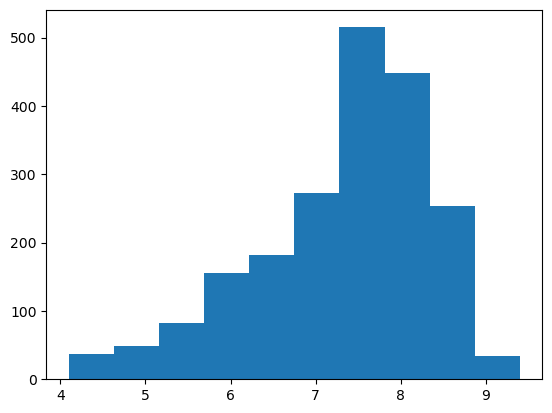

In [49]:
df_last=df_ohe.copy()
df_last=df_last.drop(df_last[df_last['Рейтинг']<=4].index,axis=0) #удаляем те самые рейтинги ниже 4 включительно
plt.hist(df_last['Рейтинг'])

Из графика заметно, что у нас все ещё скошенное распределение, однако левый хвост выбросов мы всё же уменьшили. Помимо этого хотим обратить внимание, что взяли df_ohe по причине, что он уже обработан с помощью OneHotEncoding, а как мы помним данный датасет нам давал лучшие предсказания. Теперь таким же образом, как в прошлый раз, разделим наши данные на обучающую и тестовую выборки.

In [50]:
df_train_last, df_test_last = train_test_split(df_last, test_size=0.2,random_state=45)
y_train_last = df_train_last['Рейтинг']
y_test_last = df_test_last['Рейтинг'] 
X_train_last = df_train_last.drop(['Рейтинг'], axis=1)
X_test_last = df_test_last.drop(['Рейтинг'], axis=1)

Ура мы на финишной прямой!!! 

Нам осталось только скопировать значения гиперпараметров из моделей с лучшими метриками из прошлого пункта, и обучить на нашей выборке без выбросов модели.

In [62]:
model_optuna_xgb = XGBRegressor(booster= 'dart', alpha= 0.09029923304328494, 
                                subsample= 0.7779408552392788, colsample_bytree= 0.4404618096557218, max_depth= 4, 
                                min_child_weight= 8, eta= 0.09923965464055982, gamma=0.031133872473454553,
                                random_state=45) 

model_optuna_xgb.fit(X_train_last,y_train_last)
prob_last=model_optuna_xgb.predict(X_test_last)
print("MSE = %.4f" % metrics.mean_squared_error(y_test_last, prob_last))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_last, prob_last))
print('MAPE = %.4f' % metrics.mean_absolute_percentage_error(y_test_last, prob_last))

MSE = 0.5536
MAE = 0.5788
MAPE = 0.0846


In [52]:
model_optuna_for = RandomForestRegressor(n_estimators=33, max_depth= 7, random_state=95) 

model_optuna_for.fit(X_train_last,y_train_last)
prob_forest_last=model_optuna_for.predict(X_test_last)
print("MSE = %.4f" % metrics.mean_squared_error(y_test_last, prob_forest_last))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_last, prob_forest_last))

MSE = 0.5997
MAE = 0.6000


In [53]:
n_estimators = np.arange(1,100,10)
max_depth = np.arange(2,20)

parametr_last={'n_estimators':n_estimators,'max_depth':max_depth} 
forest_last=RandomForestRegressor(random_state=41)
searcher_last = GridSearchCV(
    forest_last, parametr_last, 
    scoring="neg_root_mean_squared_error", cv=10,n_jobs=-1)
searcher_last.fit(X_train_last, y_train_last)
y_pred_last = searcher_last.predict(X_test_last)

print("MSE = %.4f" % metrics.mean_squared_error(y_test_last, y_pred_last))
print("MAE = %.4f" % metrics.mean_absolute_error(y_test_last, y_pred_last)) 

MSE = 0.6162
MAE = 0.6089


<center>

## Вывод итоговый:

</center>

После удаления выбросов, только XGBRegressor дал оптимальный результат (MSE = 0.5536, MAE = 0.5788). Специально для лучшей модели мы также рассчитали метрику MAPE = 0.0846, которая говорит, что в среднем наши прогнозы отличаются от фактических значений на 8,46%. Касательно метрик MSE и MAE можно подчеркнуть причину, по которой наши лучшие метрики обучения принимают столько высокие показатели. Она кроется в том, что MSE чувствительно к выбрасам, даже после удаления фильмов с рейтингом ниже 4 распределение рейтинга всё равно осталось скошенным, поэтому левый хвост значений может быть воспринят MSE, как выбросы, что, безусловно, ухудшит предсказания. Переходя к MAE, то полученную величину можно интерпретировать так: в среднем наши предсказания на 0,57 разнятся с истинными. Насколько это большое расхождение нельзя ответить на первый взгляд, но, полагам, построение доверительного интервала могло разрешить эту проблему. Считая, что рейтинг лежит в диапазоне от 4 до 10, то в этом случае величина 0,57 составляет 1/12 (считая в 1 лежит два раза по 0,5), то есть около 0,08.

Мы можем предположить, что, наверное, данные метрики могут принимать значения и меньше, но для этого будет необходимо рассматривать большую выборку и её признаков соответственно.\
Изначально мы планировали парсить данные с Кинопоиска, так как там можно было найти информацию о бюджете фильма, IMDb и количество оценок для этого рейтинга. Однако структура сайта оказалась сложной, поэтому мы перешли на иви (да,да теперь он пишется на русском). Из плюсов: ИВИ обладает большей библиотекой, чем Кинопоиск, однако парсинг более 80 страниц занимает очень много времени, что затрудняет сбор большего количества данных.\
Соответственно, можно полагать, что с увеличением базы данных и признаков к ним будет более точно предсказываться рейтинг.